In [1]:
"""
Confusion Matrix Analysis for Problem Categories
Visual analysis showing which categories are confused with each other
"""
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm

# Find project root
current = Path.cwd()
while current != current.parent:
    if (current / 'src').exists():
        project_root = current
        break
    current = current.parent
else:
    project_root = Path.cwd().parent

# Add src to path
src_path = str(project_root / 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(f"Project root: {project_root}")

# Import retriever
from retrieval.retriever import KnowledgeBaseRetriever

# Load test data
print("Loading test data...")
test_df = pd.read_csv(project_root / 'data/processed/test_processed.csv')
vector_db_path = str(project_root / 'data/vector_db')

print("Initializing retriever...")
retriever = KnowledgeBaseRetriever(vector_db_path, use_reranking=False)


Project root: c:\Users\victo\customer-support-rag
Loading test data...
Initializing retriever...


In [2]:
# =============================================================================
# BUILD CONFUSION MATRIX FOR PROBLEM CATEGORIES
# =============================================================================
print("\n" + "="*80)
print("BUILDING CONFUSION MATRIX FOR PROBLEM CATEGORIES")
print("="*80)

problem_categories = [
    'pending_transfer', 
    'card_payment_not_recognised', 
    'balance_not_updated_after_bank_transfer'
]

# Also include the categories they're confused with
related_categories = [
    'transfer_timing',
    'failed_transfer',
    'transfer_not_received_by_recipient',
    'direct_debit_payment_not_recognised',
    'pending_transfer',
    'card_payment_not_recognised',
    'balance_not_updated_after_bank_transfer'
]

# Remove duplicates
all_categories = list(set(problem_categories + related_categories))
all_categories.sort()

print(f"\nAnalyzing {len(all_categories)} categories:")
for cat in all_categories:
    print(f"  • {cat}")

# Build confusion matrix
confusion_data = defaultdict(lambda: defaultdict(int))
total_per_true_category = defaultdict(int)

print(f"\nProcessing test queries...")
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Building matrix"):
    true_category = row['category']
    
    # Only track if true category is in our list
    if true_category not in all_categories:
        continue
    
    # Get prediction
    result = retriever.retrieve(row['text'], n_results=1)
    predicted_category = result['metadatas'][0]['category']
    
    # Record prediction
    confusion_data[true_category][predicted_category] += 1
    total_per_true_category[true_category] += 1

# Convert to matrix format
matrix = np.zeros((len(all_categories), len(all_categories)))

for i, true_cat in enumerate(all_categories):
    for j, pred_cat in enumerate(all_categories):
        count = confusion_data[true_cat][pred_cat]
        total = total_per_true_category[true_cat]
        if total > 0:
            matrix[i, j] = count / total  # Normalize by row (percentage)



BUILDING CONFUSION MATRIX FOR PROBLEM CATEGORIES

Analyzing 7 categories:
  • balance_not_updated_after_bank_transfer
  • card_payment_not_recognised
  • direct_debit_payment_not_recognised
  • failed_transfer
  • pending_transfer
  • transfer_not_received_by_recipient
  • transfer_timing

Processing test queries...


Building matrix: 100%|██████████| 3080/3080 [01:45<00:00, 29.29it/s]



GENERATING CONFUSION MATRIX VISUALIZATIONS
✅ Saved: c:\Users\victo\customer-support-rag\confusion_matrix_problem_categories.png


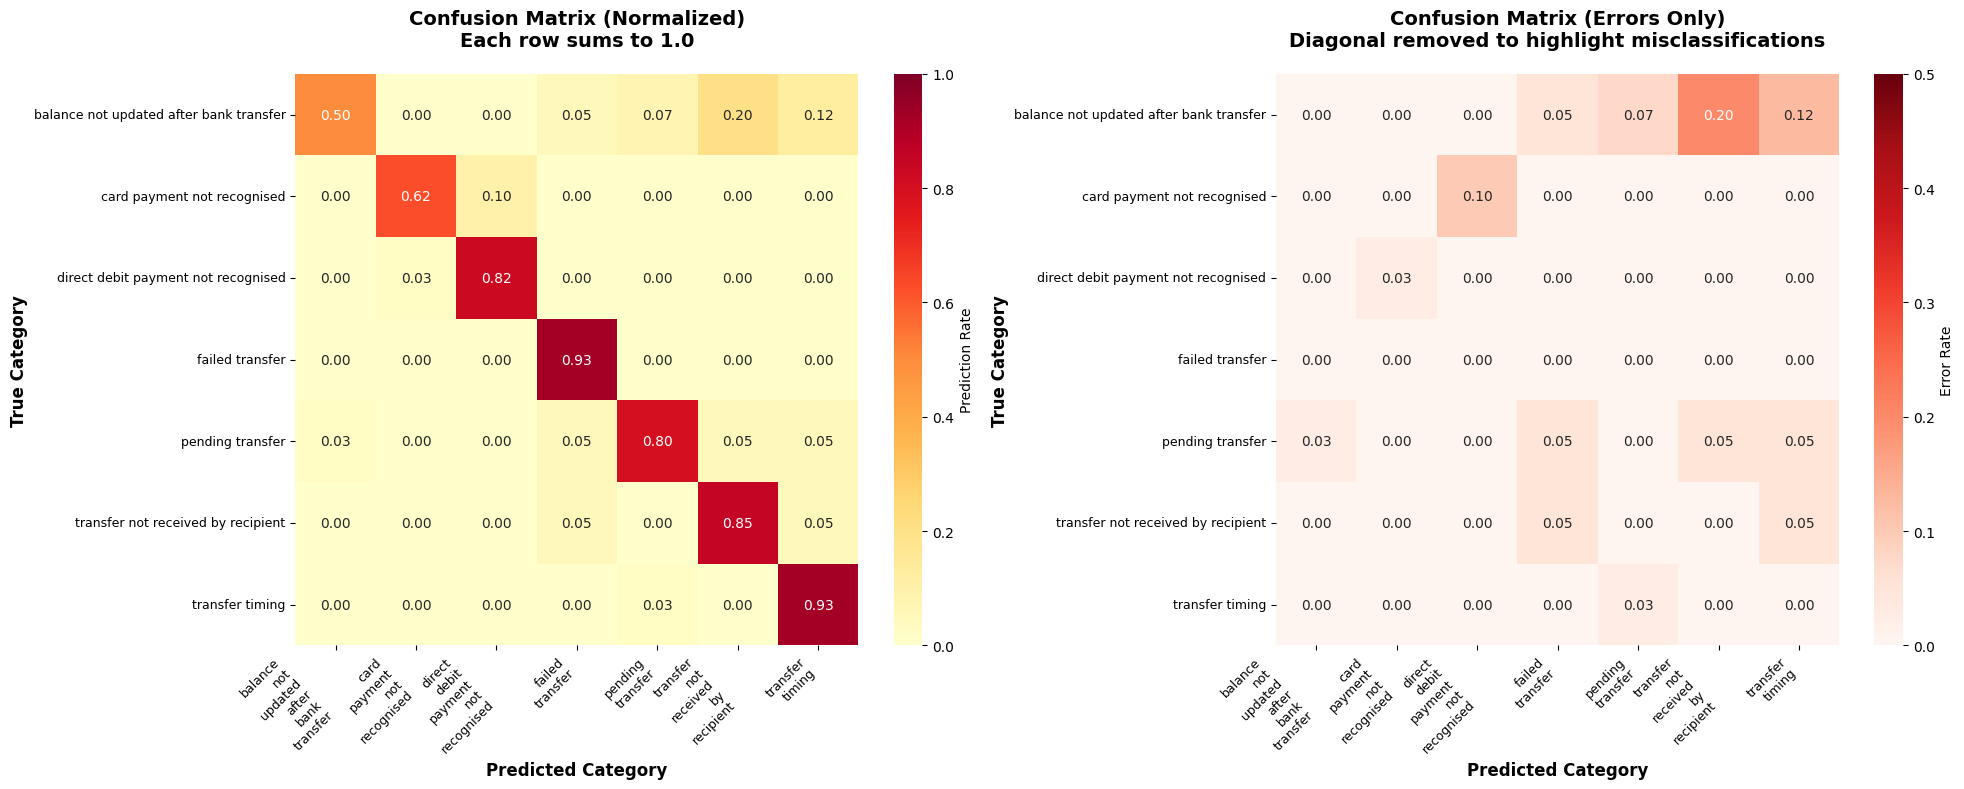

In [3]:
# =============================================================================
# VISUALIZATION 1: Full Confusion Matrix (Normalized)
# =============================================================================
print("\n" + "="*80)
print("GENERATING CONFUSION MATRIX VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap 1: Normalized confusion matrix (percentages)
sns.heatmap(matrix, 
            annot=True, 
            fmt='.2f',
            cmap='YlOrRd',
            xticklabels=[cat.replace('_', '\n') for cat in all_categories],
            yticklabels=[cat.replace('_', ' ') for cat in all_categories],
            cbar_kws={'label': 'Prediction Rate'},
            ax=axes[0],
            vmin=0,
            vmax=1)
axes[0].set_xlabel('Predicted Category', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Category', fontsize=12, fontweight='bold')
axes[0].set_title('Confusion Matrix (Normalized)\nEach row sums to 1.0', 
                  fontsize=14, fontweight='bold', pad=20)

# Rotate labels for readability
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=9)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0, fontsize=9)

# Heatmap 2: Focus on off-diagonal (errors only)
error_matrix = matrix.copy()
np.fill_diagonal(error_matrix, 0)  # Remove correct predictions

sns.heatmap(error_matrix, 
            annot=True, 
            fmt='.2f',
            cmap='Reds',
            xticklabels=[cat.replace('_', '\n') for cat in all_categories],
            yticklabels=[cat.replace('_', ' ') for cat in all_categories],
            cbar_kws={'label': 'Error Rate'},
            ax=axes[1],
            vmin=0,
            vmax=0.5)
axes[1].set_xlabel('Predicted Category', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Category', fontsize=12, fontweight='bold')
axes[1].set_title('Confusion Matrix (Errors Only)\nDiagonal removed to highlight misclassifications', 
                  fontsize=14, fontweight='bold', pad=20)

axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=9)
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig(project_root / 'confusion_matrix_problem_categories.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved: {project_root / 'confusion_matrix_problem_categories.png'}")
plt.show()



TOP CONFUSION PAIRS

Top 10 Confusion Pairs (>5% error rate):
--------------------------------------------------------------------------------
balance_not_updated_after_bank_transfer       → transfer_not_received_by_recipient            : 20.0% (8 queries)
balance_not_updated_after_bank_transfer       → transfer_timing                               : 12.5% (5 queries)
card_payment_not_recognised                   → direct_debit_payment_not_recognised           : 10.0% (4 queries)
balance_not_updated_after_bank_transfer       → pending_transfer                              : 7.5% (3 queries)

✅ Saved: c:\Users\victo\customer-support-rag\top_confusion_pairs.png


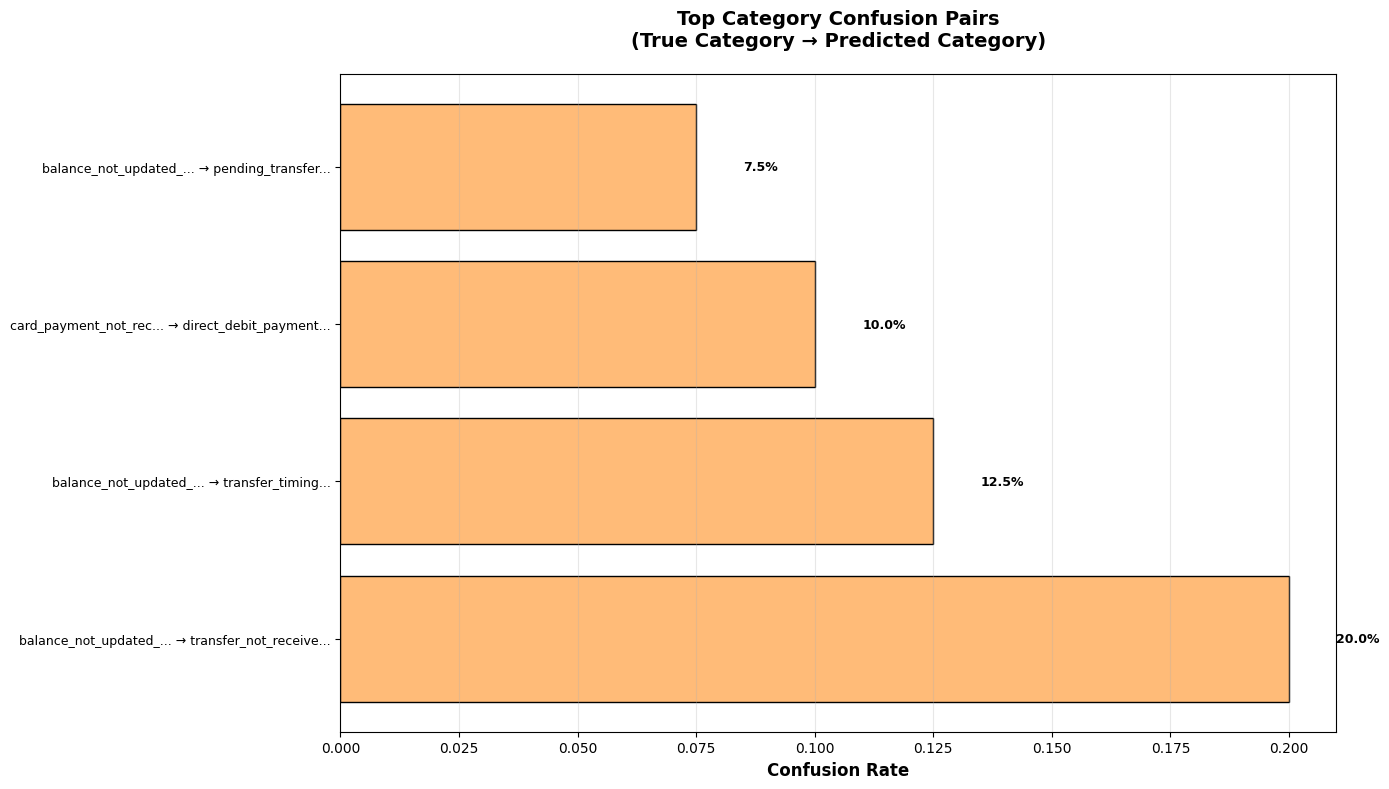

In [4]:
# =============================================================================
# VISUALIZATION 2: Top Confusion Pairs
# =============================================================================
print("\n" + "="*80)
print("TOP CONFUSION PAIRS")
print("="*80)

# Extract top confusion pairs (excluding diagonal)
confusion_pairs = []
for i, true_cat in enumerate(all_categories):
    for j, pred_cat in enumerate(all_categories):
        if i != j and matrix[i, j] > 0.05:  # Only pairs with >5% confusion
            confusion_pairs.append({
                'true': true_cat,
                'predicted': pred_cat,
                'rate': matrix[i, j],
                'count': confusion_data[true_cat][pred_cat]
            })

confusion_df = pd.DataFrame(confusion_pairs)
confusion_df = confusion_df.sort_values('rate', ascending=False)

print("\nTop 10 Confusion Pairs (>5% error rate):")
print("-" * 80)
for idx, row in confusion_df.head(10).iterrows():
    print(f"{row['true']:45s} → {row['predicted']:45s} : {row['rate']:.1%} ({int(row['count'])} queries)")

# Bar chart of top confusion pairs
fig, ax = plt.subplots(figsize=(14, 8))

top_n = min(15, len(confusion_df))
top_confusions = confusion_df.head(top_n)

# Create labels
labels = [f"{row['true'][:20]}... → {row['predicted'][:20]}..." 
          for idx, row in top_confusions.iterrows()]

colors = ['#d62728' if rate > 0.3 else '#ff7f0e' if rate > 0.2 else '#ffbb78' 
          for rate in top_confusions['rate']]

bars = ax.barh(range(len(labels)), top_confusions['rate'], color=colors, edgecolor='black')
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels, fontsize=9)
ax.set_xlabel('Confusion Rate', fontsize=12, fontweight='bold')
ax.set_title('Top Category Confusion Pairs\n(True Category → Predicted Category)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, rate) in enumerate(zip(bars, top_confusions['rate'])):
    ax.text(rate + 0.01, i, f'{rate:.1%}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(project_root / 'top_confusion_pairs.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Saved: {project_root / 'top_confusion_pairs.png'}")
plt.show()



PER-CATEGORY ACCURACY

Category Accuracy (sorted by performance):
--------------------------------------------------------------------------------
❌ balance_not_updated_after_bank_transfer            : 50.0% (20/40)
❌ card_payment_not_recognised                        : 62.5% (25/40)
⚠️ pending_transfer                                   : 80.0% (32/40)
✅ direct_debit_payment_not_recognised                : 82.5% (33/40)
✅ transfer_not_received_by_recipient                 : 85.0% (34/40)
✅ failed_transfer                                    : 92.5% (37/40)
✅ transfer_timing                                    : 92.5% (37/40)

✅ Saved: c:\Users\victo\customer-support-rag\per_category_accuracy.png


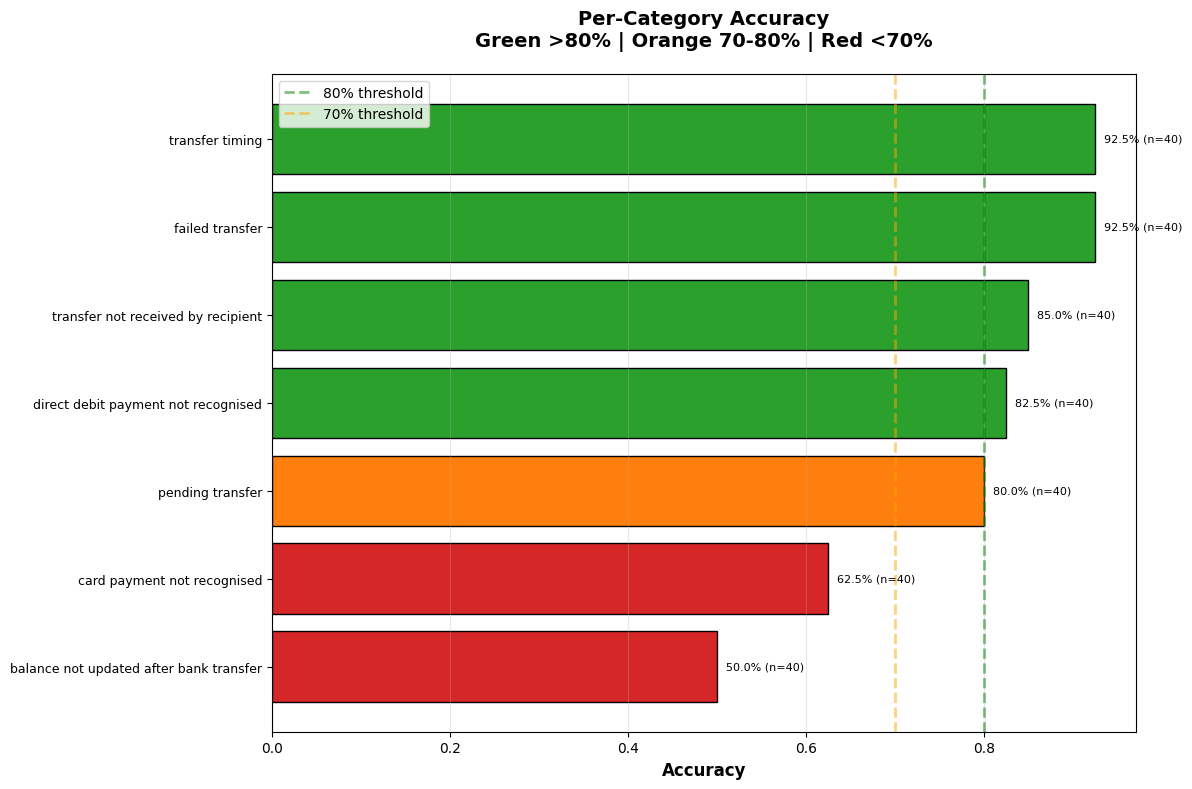

In [5]:
# =============================================================================
# VISUALIZATION 3: Per-Category Accuracy
# =============================================================================
print("\n" + "="*80)
print("PER-CATEGORY ACCURACY")
print("="*80)

category_accuracy = []
for i, cat in enumerate(all_categories):
    correct = confusion_data[cat][cat]
    total = total_per_true_category[cat]
    accuracy = correct / total if total > 0 else 0
    category_accuracy.append({
        'category': cat,
        'accuracy': accuracy,
        'total': total,
        'correct': correct
    })

accuracy_df = pd.DataFrame(category_accuracy)
accuracy_df = accuracy_df.sort_values('accuracy')

print("\nCategory Accuracy (sorted by performance):")
print("-" * 80)
for idx, row in accuracy_df.iterrows():
    status = "✅" if row['accuracy'] > 0.8 else "⚠️" if row['accuracy'] > 0.7 else "❌"
    print(f"{status} {row['category']:50s} : {row['accuracy']:.1%} ({int(row['correct'])}/{int(row['total'])})")

# Bar chart
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#2ca02c' if acc > 0.8 else '#ff7f0e' if acc > 0.7 else '#d62728' 
          for acc in accuracy_df['accuracy']]

bars = ax.barh(range(len(accuracy_df)), accuracy_df['accuracy'], color=colors, edgecolor='black')
ax.set_yticks(range(len(accuracy_df)))
ax.set_yticklabels([cat.replace('_', ' ') for cat in accuracy_df['category']], fontsize=9)
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Per-Category Accuracy\nGreen >80% | Orange 70-80% | Red <70%', 
             fontsize=14, fontweight='bold', pad=20)
ax.axvline(0.8, color='green', linestyle='--', alpha=0.5, linewidth=2, label='80% threshold')
ax.axvline(0.7, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='70% threshold')
ax.grid(axis='x', alpha=0.3)
ax.legend()

# Add value labels
for i, (bar, acc, total) in enumerate(zip(bars, accuracy_df['accuracy'], accuracy_df['total'])):
    ax.text(acc + 0.01, i, f'{acc:.1%} (n={int(total)})', va='center', fontsize=8)

plt.tight_layout()
plt.savefig(project_root / 'per_category_accuracy.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Saved: {project_root / 'per_category_accuracy.png'}")
plt.show()

In [6]:
# =============================================================================
# SUMMARY STATISTICS
# =============================================================================
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nOverall Statistics:")
print(f"  Categories analyzed: {len(all_categories)}")
print(f"  Total test queries: {sum(total_per_true_category.values())}")
print(f"  Average accuracy: {accuracy_df['accuracy'].mean():.1%}")
print(f"  Best performing: {accuracy_df.iloc[-1]['category']} ({accuracy_df.iloc[-1]['accuracy']:.1%})")
print(f"  Worst performing: {accuracy_df.iloc[0]['category']} ({accuracy_df.iloc[0]['accuracy']:.1%})")

print(f"\nKey Insights:")

# Insight 1: Symmetric confusions
print(f"\n1. Bidirectional Confusion Pairs:")
print(f"   (Categories that confuse each other both ways)")
for i, cat1 in enumerate(all_categories):
    for j, cat2 in enumerate(all_categories):
        if i < j:  # Only check upper triangle
            rate_12 = matrix[i, j]
            rate_21 = matrix[j, i]
            if rate_12 > 0.1 and rate_21 > 0.1:
                print(f"   • {cat1} ⇄ {cat2}")
                print(f"     {cat1} → {cat2}: {rate_12:.1%}")
                print(f"     {cat2} → {cat1}: {rate_21:.1%}")

# Insight 2: One-way confusions
print(f"\n2. One-Way Confusion Pairs:")
print(f"   (A confused with B, but not vice versa)")
for i, cat1 in enumerate(all_categories):
    for j, cat2 in enumerate(all_categories):
        if i != j:
            rate_12 = matrix[i, j]
            rate_21 = matrix[j, i]
            if rate_12 > 0.15 and rate_21 < 0.05:
                print(f"   • {cat1} → {cat2}: {rate_12:.1%} (but reverse: {rate_21:.1%})")

# Insight 3: Categories with high self-accuracy
high_accuracy = accuracy_df[accuracy_df['accuracy'] > 0.9]
if len(high_accuracy) > 0:
    print(f"\n3. High-Performing Categories (>90% accuracy):")
    for idx, row in high_accuracy.iterrows():
        print(f"   ✅ {row['category']}: {row['accuracy']:.1%}")


SUMMARY STATISTICS

Overall Statistics:
  Categories analyzed: 7
  Total test queries: 280
  Average accuracy: 77.9%
  Best performing: transfer_timing (92.5%)
  Worst performing: balance_not_updated_after_bank_transfer (50.0%)

Key Insights:

1. Bidirectional Confusion Pairs:
   (Categories that confuse each other both ways)

2. One-Way Confusion Pairs:
   (A confused with B, but not vice versa)
   • balance_not_updated_after_bank_transfer → transfer_not_received_by_recipient: 20.0% (but reverse: 0.0%)

3. High-Performing Categories (>90% accuracy):
   ✅ failed_transfer: 92.5%
   ✅ transfer_timing: 92.5%


In [7]:
# =============================================================================
# EXPORT DATA
# =============================================================================
print("\n" + "="*80)
print("EXPORTING DATA")
print("="*80)

# Export full confusion matrix
confusion_matrix_df = pd.DataFrame(
    matrix,
    index=all_categories,
    columns=all_categories
)
confusion_path = project_root / 'data' / 'processed' / 'confusion_matrix.csv'
confusion_matrix_df.to_csv(confusion_path)
print(f"✅ Saved confusion matrix to: {confusion_path}")

# Export confusion pairs
confusion_pairs_path = project_root / 'data' / 'processed' / 'confusion_pairs.csv'
confusion_df.to_csv(confusion_pairs_path, index=False)
print(f"✅ Saved confusion pairs to: {confusion_pairs_path}")

# Export per-category accuracy
accuracy_path = project_root / 'data' / 'processed' / 'category_accuracy.csv'
accuracy_df.to_csv(accuracy_path, index=False)
print(f"✅ Saved category accuracy to: {accuracy_path}")

print("\n" + "="*80)
print("CONFUSION MATRIX ANALYSIS COMPLETE")
print("="*80)

print(f"""
📊 Generated visualizations:
  1. confusion_matrix_problem_categories.png - Full heatmap + errors only
  2. top_confusion_pairs.png - Top 15 confusion pairs
  3. per_category_accuracy.png - Accuracy by category

📁 Exported data:
  1. confusion_matrix.csv - Full normalized matrix
  2. confusion_pairs.csv - All confusion pairs with rates
  3. category_accuracy.csv - Per-category performance

""")


EXPORTING DATA
✅ Saved confusion matrix to: c:\Users\victo\customer-support-rag\data\processed\confusion_matrix.csv
✅ Saved confusion pairs to: c:\Users\victo\customer-support-rag\data\processed\confusion_pairs.csv
✅ Saved category accuracy to: c:\Users\victo\customer-support-rag\data\processed\category_accuracy.csv

CONFUSION MATRIX ANALYSIS COMPLETE

📊 Generated visualizations:
  1. confusion_matrix_problem_categories.png - Full heatmap + errors only
  2. top_confusion_pairs.png - Top 15 confusion pairs
  3. per_category_accuracy.png - Accuracy by category

📁 Exported data:
  1. confusion_matrix.csv - Full normalized matrix
  2. confusion_pairs.csv - All confusion pairs with rates
  3. category_accuracy.csv - Per-category performance


